In [1]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 9.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from transformers import ViTFeatureExtractor, ViTForImageClassification,ViTConfig
from PIL import Image
import requests

from typing import Dict, List, Optional, Set, Tuple, Union
import torch.utils.checkpoint
from torch import nn
import math

from torchvision import io, transforms
from torchvision.utils import Image, ImageDraw
from torchvision.transforms.functional import to_pil_image


Process image, feed into into ViT. Collect hidden states for later use. 

In [3]:
#picture of Marvin the dog
url = 'https://i.imgur.com/UKHBmxB.jpg' 
image = Image.open(requests.get(url, stream=True).raw)

#load pretrained ViT model for classifcation from huggingface
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224',output_hidden_states = True,output_attentions=True)

#format image to feed into transformer
inputs = feature_extractor(images=image, return_tensors="pt")

#feed formatted image into ViT, collect outputs
with torch.no_grad():
    outputs = model(**inputs) 
    logits = outputs.logits

# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

/usr/local/lib/python3.8/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Predicted class: Walker hound, Walker foxhound


Visualize patches of image. For fun. Model splits 224 px x 224 px image into 196 = 14 x 14 patches. Each patch is of size 16 px x 16 px and has three channels for RGB. 

Each patch is flattened into a vector of size 768 = 16 x 16 x 3. This vector is what is consumed by the ViT. 

The output of each ViT layer is of size 196 x 768.

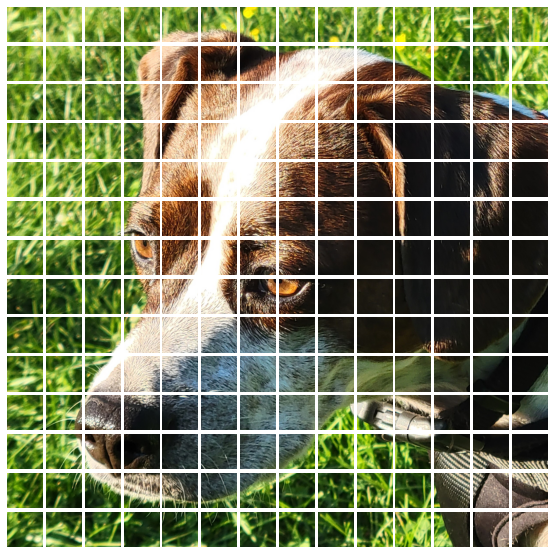

In [4]:
IMG_SIZE = 224*7
PATCH_SIZE = 16*7

NUM_PATCHES = int(IMG_SIZE/PATCH_SIZE)

transform = transforms.Compose([
transforms.PILToTensor()])

torch_image = transform(image)

resize = transforms.Resize((IMG_SIZE, IMG_SIZE))
img = resize(torch_image)

patches = img.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)

fig, ax = plt.subplots(NUM_PATCHES, NUM_PATCHES, figsize=(15, 15))
for i in range(NUM_PATCHES):
    for j in range(NUM_PATCHES):      


        sub_img = patches[:, i, j]
        ax[i][j].imshow(to_pil_image(sub_img))
        ax[i][j].axis('off')

plt.subplots_adjust(left=0, bottom=0, right=0.5, top=0.5, wspace=0.1, hspace=0.1)

#plt.savefig('marvin_grid',dpi = 300,bbox_inches='tight')

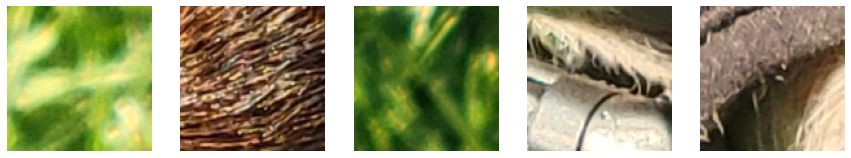

In [5]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
grid_counter = 0
for i in range(NUM_PATCHES):
    for j in range(NUM_PATCHES):
        
        counter = i*NUM_PATCHES + j      
        
        if counter in [0,50,100,150,195] and grid_counter < 5:

          sub_img = patches[:, i, j]
          ax[grid_counter].imshow(to_pil_image(sub_img))
          ax[grid_counter].axis('off')
          grid_counter += 1

plt.savefig('marvin_patches',dpi = 300,bbox_inches='tight')

Here we extract the raw attention scores from the pretrained ViT. To do this we copy the source code for a layer with ViT, and then modify it to output the raw attention scores. 

In [6]:
import transformers
from transformers.pytorch_utils import find_pruneable_heads_and_indices, prune_linear_layer
from transformers.activations import ACT2FN

class ViTSelfAttention(nn.Module):
    def __init__(self, config: ViTConfig) -> None:
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size {config.hidden_size,} is not a multiple of the number of attention "
                f"heads {config.num_attention_heads}."
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size, bias=config.qkv_bias)
        self.key = nn.Linear(config.hidden_size, self.all_head_size, bias=config.qkv_bias)
        self.value = nn.Linear(config.hidden_size, self.all_head_size, bias=config.qkv_bias)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self, hidden_states, head_mask: Optional[torch.Tensor] = None, output_attentions: bool = False
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor]]:
        mixed_query_layer = self.query(hidden_states)

        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))
        query_layer = self.transpose_for_scores(mixed_query_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs)# if output_attentions else (context_layer,)

        return outputs,attention_scores,attention_probs,query_layer,key_layer


class ViTSelfOutput(nn.Module):
    """
    The residual connection is defined in ViTLayer instead of here (as is the case with other models), due to the
    layernorm applied before each block.
    """

    def __init__(self, config: ViTConfig) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:

        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)

        return hidden_states


class ViTAttention(nn.Module):
    def __init__(self, config: ViTConfig) -> None:
        super().__init__()
        self.attention = ViTSelfAttention(config)
        self.output = ViTSelfOutput(config)
        self.pruned_heads = set()

    def prune_heads(self, heads: Set[int]) -> None:
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.attention.num_attention_heads, self.attention.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.attention.query = prune_linear_layer(self.attention.query, index)
        self.attention.key = prune_linear_layer(self.attention.key, index)
        self.attention.value = prune_linear_layer(self.attention.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.attention.num_attention_heads = self.attention.num_attention_heads - len(heads)
        self.attention.all_head_size = self.attention.attention_head_size * self.attention.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor]]:
        
        
        self_outputs, attention_scores,attention_probs,query_layer,key_layer = self.attention(hidden_states, head_mask, output_attentions)

        attention_output = self.output(self_outputs[0], hidden_states)

        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs, attention_scores

class ViTIntermediate(nn.Module):
    def __init__(self, config: ViTConfig) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:

        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)

        return hidden_states

class ViTOutput(nn.Module):
    def __init__(self, config: ViTConfig) -> None:
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)

        hidden_states = hidden_states + input_tensor

        return hidden_states

class ViTLayer(nn.Module):
    """This corresponds to the Block class in the timm implementation."""

    def __init__(self, config: ViTConfig) -> None:
        super().__init__()
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = ViTAttention(config)
        self.intermediate = ViTIntermediate(config)
        self.output = ViTOutput(config)
        self.layernorm_before = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.layernorm_after = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor]]:
        self_attention_outputs,attention_scores,attention_probs,query_layer,key_layer = self.attention(
            self.layernorm_before(hidden_states),  # in ViT, layernorm is applied before self-attention
            head_mask,
            output_attentions=output_attentions,
        )
        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        # first residual connection
        hidden_states = attention_output + hidden_states

        # in ViT, layernorm is also applied after self-attention
        layer_output = self.layernorm_after(hidden_states)
        layer_output = self.intermediate(layer_output)

        # second residual connection is done here
        layer_output = self.output(layer_output, hidden_states)

        outputs = (layer_output,) + outputs

        return outputs, attention_scores,attention_probs,query_layer,key_layer

In [7]:
#get block of pretrained ViT
layer_num = 6
#pick an attention head
nhead = 5
#block of pretrained ViT
vit_block = model.vit.encoder.layer[layer_num]

#instantiate custom self-attention
custom_self_attn = ViTSelfAttention(config = model.config)
custom_self_attn.key = vit_block.attention.attention.key
custom_self_attn.value = vit_block.attention.attention.value
custom_self_attn.query = vit_block.attention.attention.query

#instantiate custom output
custom_output = ViTOutput(config = model.config)
custom_output.dense = vit_block.output.dense
custom_output.dropout = vit_block.output.dropout

#instantiate custom attention
custom_attn = ViTSelfAttention(config = model.config)
custom_attn.attention = custom_self_attn
custom_attn.output = custom_output

#instantiate custom intermediate
custom_intermediate = ViTIntermediate(config = model.config)
custom_intermediate.dense = vit_block.intermediate.dense

#instantiate custom layer
custom_layer = ViTLayer(config = model.config)
custom_layer.attention = custom_attn
custom_layer.intermediate = custom_intermediate
custom_layer.output = custom_output


#pass in outputs of previous layer
outputs_of_previous_layer = outputs['hidden_states'][layer_num-1]
custom_outputs,attention_scores,attention_probs,query_layer,key_layer = custom_layer(outputs_of_previous_layer)

#normalize Q and K matrices appropriately 
query_layer /= custom_attn.attention_head_size**(1/4)
key_layer /= custom_attn.attention_head_size**(1/4)

query_layer = query_layer.detach().numpy()
key_layer = key_layer.detach().numpy()

Define random feature functions here. We show that our Neuron-Astrocyte network is equivalent to a linear Transformer with random feature attention. This relies on the decomposition:

$$e^{x^Ty} \approx \phi(x)^T \phi(y) $$

There are many different possible choices for $\phi$, each with varying biological interpretations/plausibility.

In [8]:
rand_seed = 16

np.random.seed(rand_seed) #for reproducibility

def get_phi(m,D,which_phi = 'performer'):
  
  '''Function that returns the random feature map, phi. 
  Since our neuron-astrocyte model is equivalent to using Random Feature Attention, we use this representation for simplicity. 
  Different phi functions lead to different feature maps.'''

  #random weight matrix for random feature map
  W = np.random.normal(0,1,(m,D))

  if which_phi == 'cosine':
    #random biases for cosine feature map
    rand_b = np.random.uniform(0,2*np.pi,m)

    def phi(x,c = 0):
      '''Uses an cosine  random feature map to approximate softmax attention.'''
      return np.sqrt(2/m)*np.cos(W @ x + rand_b)*np.exp(0.5*(np.linalg.norm(x)**2) - c)


  if which_phi == 'performer':
    def phi(x,c = 0):
      '''Uses an exponential random feature map to approximate softmax attention.'''
      #x has dimensions of the encoded tokens (for albert this is m = 768)
      return np.exp( -0.5*np.log(m) + W @ x - 0.5*(np.linalg.norm(x)**2))

  if which_phi == 'linear':
    def phi(x,c = 0):
      '''Uses an exponential random feature map to approximate softmax attention.'''
      #x has dimensions of the encoded tokens (for albert this is m = 768)
      h =  -0.5*np.log(m) + W @ x - 0.5*(np.linalg.norm(x)**2)
      return 1 + h

  if which_phi == 'truncated_performer':
    def phi(x,thresh = 150):
      '''Uses an exponential random feature map to approximate softmax attention.'''
      #x has dimensions of the encoded tokens (for albert this is m = 768)
      scaling_factors = np.exp( -0.5*np.log(m) - 0.5*(np.linalg.norm(x)**2))
      h = np.exp(W @ x)
      return scaling_factors*np.maximum(0,np.minimum(h,thresh))

  if which_phi == 'positive_cosine':
    #random biases for cosine feature map
    rand_b = np.random.uniform(0,2*np.pi,m)
    def phi(x,thresh = 10):
      '''Uses an exponential random feature map to approximate softmax attention.'''
      #x has dimensions of the encoded tokens (for albert this is m = 768)
      scaling_factors = np.sqrt(2/(np.pi*m))*np.exp(0.5*(np.linalg.norm(x)**2))
      h = np.cos(W @ x + rand_b)
      return np.maximum(0,scaling_factors*h)

  if which_phi == 'dima_sin':
    #random biases for cosine feature map
    rand_b = np.random.uniform(0,2*np.pi,m)

    def clipped_sin(x):      
      if -np.pi/2 < x < np.pi/2:
        y = np.sin(x)
      if x > np.pi/2:
        y = 1
      if x < -np.pi/2:
        y = -1

      return y

    v_clipped_sin = np.vectorize(clipped_sin)       


    def phi(x,thresh = 10):
      '''Uses an exponential random feature map to approximate softmax attention.'''
      #x has dimensions of the encoded tokens (for albert this is m = 768)
      scaling_factors = np.sqrt(2/m)*np.exp(0.5*(np.linalg.norm(x)**2))
      h = v_clipped_sin(W @ x + rand_b)
      return scaling_factors*h #np.maximum(0,scaling_factors*h)

  return phi

Computing astrocyte response here for different numbers of hidden neurons in the Neuron-Astrocyte networks. 

In [10]:
np.random.seed(rand_seed) 
def get_astro_responses(query_layer,key_layer,nhead,phi):
  '''Computes astrocyte response given a random feature map, queries, and keys.'''

  ntokens = query_layer.shape[2]

  rfa_key_sum = 0
  for i in range(ntokens):  
    rfa_normalized_keys = phi(key_layer[0,nhead,i,:])
    rfa_key_sum += rfa_normalized_keys

  astro_ps = np.zeros(ntokens)

  for t in range(ntokens):
    q_t = query_layer[0,nhead,t]
    astro_ps[t] = np.dot(phi(q_t),rfa_key_sum)

  return astro_ps

#Constructing phi (random features)
phi_high_m = get_phi(m = int(1e5), D = custom_attn.attention_head_size,which_phi = 'performer') 
phi_low_m = get_phi(m = int(1e3), D = custom_attn.attention_head_size,which_phi = 'performer') 

astro_ps_low_m = get_astro_responses(query_layer,key_layer,nhead,phi_low_m)
astro_ps_high_m = get_astro_responses(query_layer,key_layer,nhead,phi_high_m)

attention_normalizations = torch.exp(attention_scores[0,nhead]).sum(-1).detach().numpy()


(0.0, 200.0)

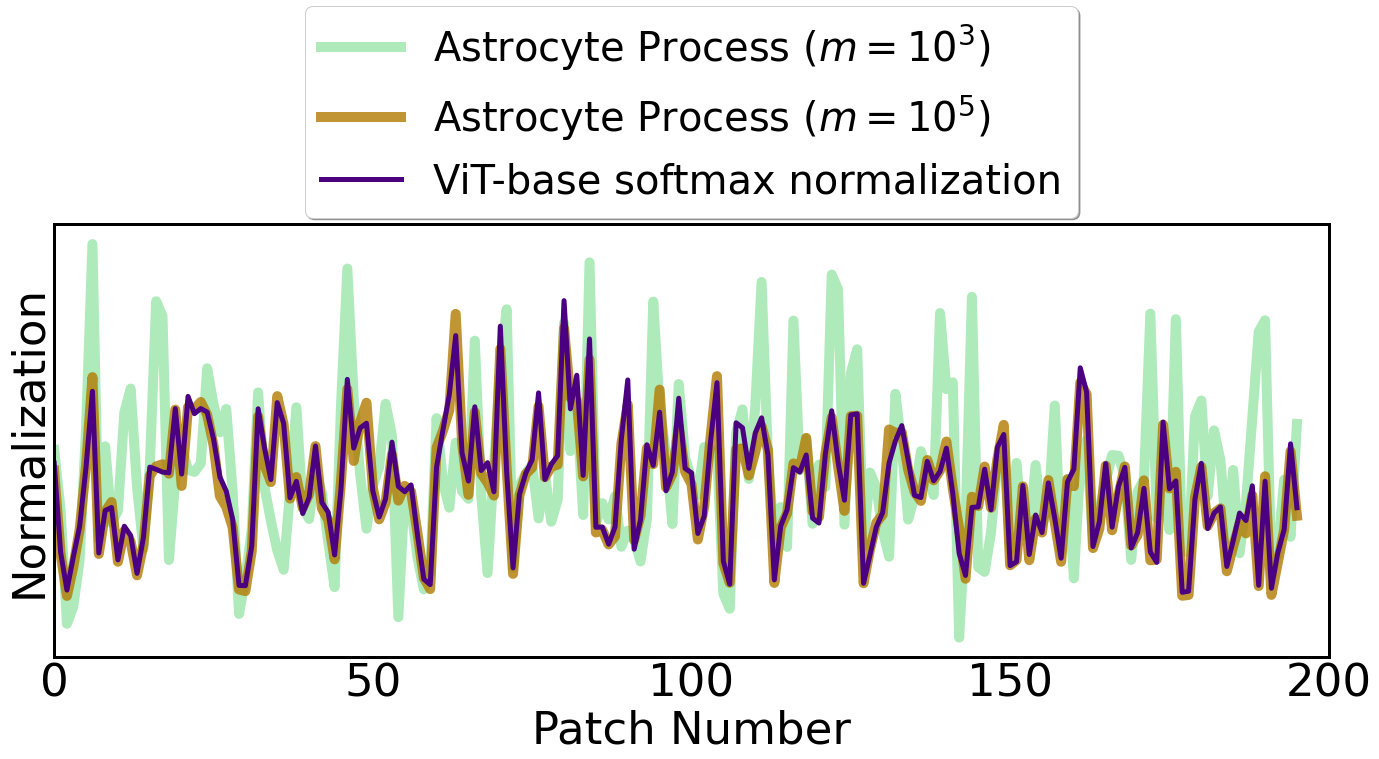

In [11]:
#plot astrocyte process state against "true" ViT normalization values

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 3
plt.grid(False)
fs = 45

t_to_plot_until = 196


plt.plot(astro_ps_low_m[:t_to_plot_until],color = '#9be5aa',linewidth = 10,alpha = 0.8,label = r'Astrocyte Process ($m = 10^3$)')#,linestyle = 'dotted')
plt.plot(astro_ps_high_m[:t_to_plot_until],color = '#b27a01',linewidth = 10,alpha = 0.8,label = r'Astrocyte Process ($m = 10^5$)')
plt.plot(attention_normalizations[:t_to_plot_until],color = 'indigo',linewidth = 5,label = r'ViT-base softmax normalization')
plt.tight_layout()
plt.legend(fontsize = 40,loc='upper center',shadow = True, bbox_to_anchor=(0.5, 1.55),fancybox = True)


plt.tick_params(length = 1,width = 2)
fig = plt.gcf()
fig.set_size_inches(20, 7)
plt.yticks([])
plt.xticks(np.arange(0,250,50),np.arange(0,250,50),fontsize=fs)
plt.xlabel('Patch Number',fontsize = fs)
plt.ylabel('Normalization',fontsize = fs)

y_lim_slack = 50
#plt.ylim(np.min(astro_ps_low_D)-y_lim_slack,np.max(astro_ps_low_D)+y_lim_slack)

plt.xlim(0,200)

#plt.savefig('ViT_softmax.png',dpi = 300,bbox_inches='tight')
